<a href="https://colab.research.google.com/github/GimenesPaula/GimenesPaula/blob/main/HSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Coloração pessoal:
 temperatura
 a profundidade
 a intensidade
 nível de contraste.  

In [1]:
pip install colour

In [2]:
pip install extcolors

In [3]:
#hsv
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
#Dominant Color
from sklearn.cluster import KMeans
from collections import Counter
import pprint

In [5]:
#Color Pallet
import PIL
from PIL import Image, ImageDraw
import extcolors
import math
from matplotlib import gridspec

In [6]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  # Defining HSV Threadholds
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)

  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)

  # Extracting skin from the threshold mask
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)

  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)


In [7]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):

  # Variable to keep count of the occurance of each color predicted
  occurance_counter = None

  # Output list variable to return
  colorInformation = []


  #Check for Black
  hasBlack =False

  # If a mask has be applied, remove th black
  if hasThresholding == True:

    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black

  else:
    occurance_counter = Counter(estimator_labels)

  # Get the total sum of all the predicted occurances
  totalOccurance = sum(occurance_counter.values())


  # Loop through all the predicted colors
  for x in occurance_counter.most_common(len(estimator_cluster)):

    index = (int(x[0]))

    # Quick fix for index out of bound when there is no threshold
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index

    # Get the color number into a list
    color = estimator_cluster[index].tolist()

    # Get the percentage of each color
    color_percentage= (x[1]/totalOccurance)

    #make the dictionay of the information
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }

    # Add the dictionary to the list
    colorInformation.append(colorInfo)


  return colorInformation

In [8]:
def removeBlack(estimator_labels, estimator_cluster):


  # Check for black
  hasBlack = False

  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)


  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)

  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):

    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]



    # Check if the color is [0,0,0] that if it is black
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break


  return (occurance_counter,estimator_cluster,hasBlack)



In [9]:

#Default is 1 ,
#pass the parameter 'number_of_colors=N' where N is the specified number of colors
def extractDominantColor(image,number_of_colors=5,hasThresholding=False):

  # Quick Fix Increase cluster counter to neglect the black(Read Article)
  if hasThresholding == True:
    number_of_colors +=1

  # Taking Copy of the image
  img = image.copy()

  # Convert Image into RGB Colours Space
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)

  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)

  # Fit the image
  estimator.fit(img)

  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation



In [10]:
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,500,3), dtype="uint8")

  top_x = 0
  for x in colorInformation:
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))

    cv2.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x
  return color_bar

In [11]:
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()

In [12]:
def study_image(img):
  colors = extract_colors(img)
  color_palette = render_color_platte(colors)
  overlay_palette(img, color_palette)

In [13]:

def extract_colors(img):
  tolerance = 32
  limit = 24
  colors, pixel_count = extcolors.extract_from_image(img, tolerance, limit)
  return colors

def render_color_platte(colors):
  size = 100
  columns = 6
  width = int(min(len(colors), columns) * size)
  height = int((math.floor(len(colors) / columns) + 1) * size)
  result = Image.new("RGBA", (width, height), (0, 0, 0, 0))
  canvas = ImageDraw.Draw(result)
  for idx, color in enumerate(colors):
      x = int((idx % columns) * size)
      y = int(math.floor(idx / columns) * size)
      canvas.rectangle([(x, y), (x + size - 1, y + size - 1)], fill=color[0])
  return result

def overlay_palette(img, color_palette):
  nrow = 2
  ncol = 1
  f = plt.figure(figsize=(20,30), facecolor='None', edgecolor='k', dpi=55, num=None)
  gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0)
  f.add_subplot(2, 1, 1)
  plt.imshow(img, interpolation='nearest')
  plt.axis('off')
  f.add_subplot(1, 2, 2)
  plt.imshow(color_palette, interpolation='nearest')
  plt.axis('off')
  plt.subplots_adjust(wspace=0, hspace=0, bottom=0)
  plt.show(block=True)

In [14]:
#Importa arquivo a ser tratado
from google.colab import files
imagem = files.upload()
filename = next(iter(imagem))

Saving Rostos Para Maquiar.jpg to Rostos Para Maquiar.jpg


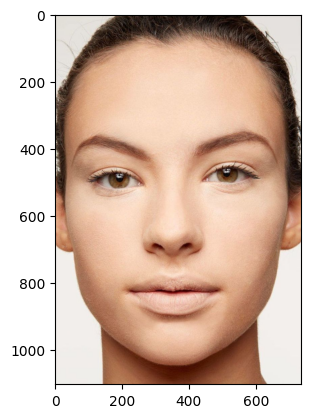

In [15]:
face = cv2.imread(filename)
img = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.imshow(img)

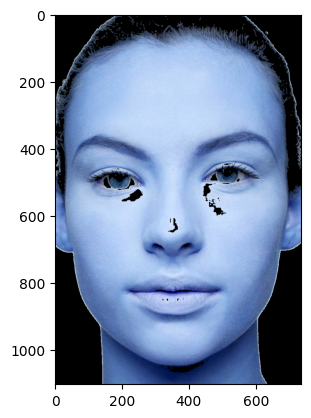

In [16]:
skin = extractSkin(face)
plt.imshow(skin)

Color Bar


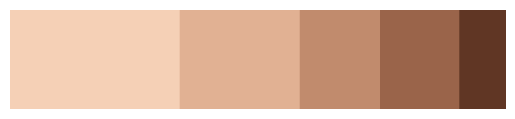

In [17]:
# Find the dominant color.
dominantColors = extractDominantColor(skin,hasThresholding=True)

#Show in the dominant color information
#print("Color Information")
#prety_print_data(dominantColors)

#Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.axis("off")
plt.imshow(colour_bar)
plt.show()

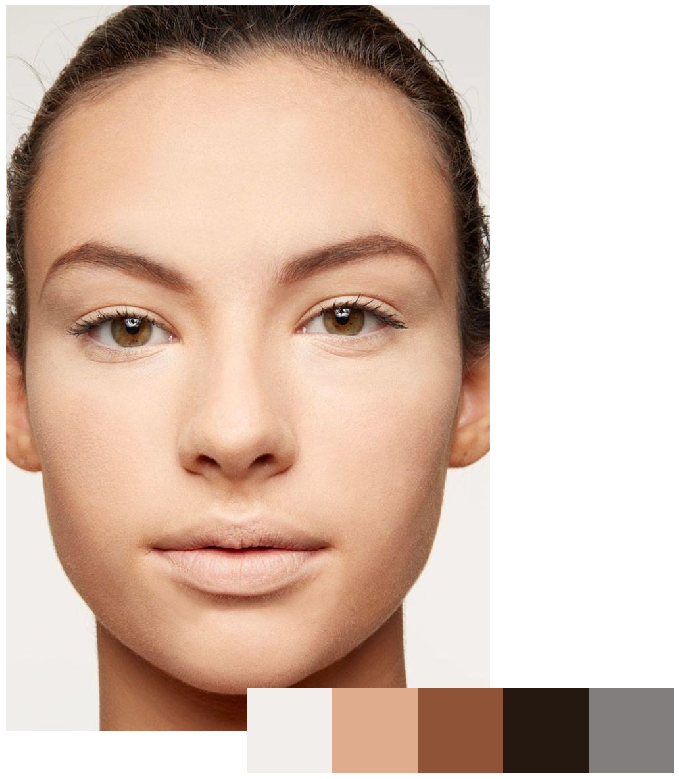

In [18]:
#Build Pallet from picture
img2 = PIL.Image.open(filename)
study_image(img2)

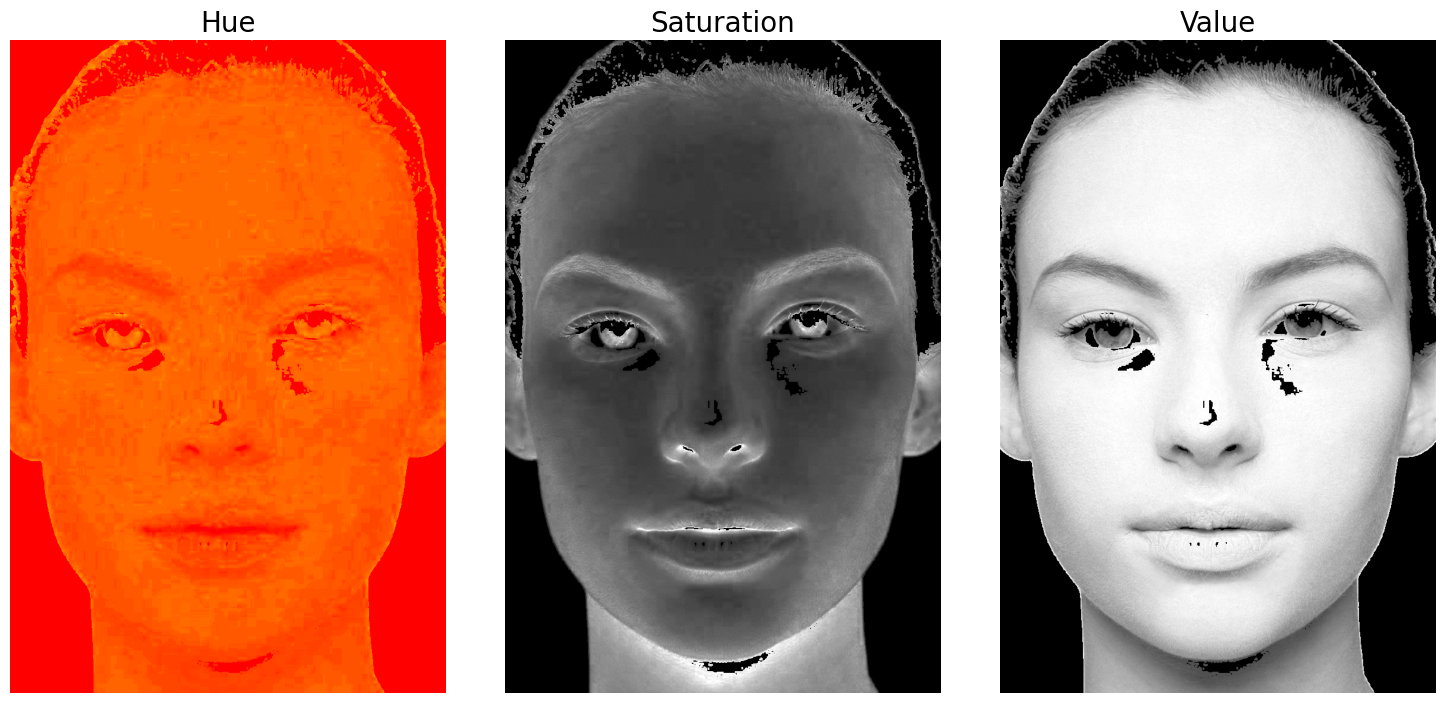

In [19]:
def display_as_hsv(img):

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    hsv_list = ['Hue','Saturation','Value']
    fig, ax = plt.subplots(1, 3, figsize=(15,7), sharey = True) ##the figure has 1 row, 3 columns.

    ax[0].imshow(img_hsv[:,:,0], cmap = 'hsv')
    ax[0].set_title(hsv_list[0], fontsize = 20)
    ax[0].axis('off')


    ax[1].imshow(img_hsv[:,:,1], cmap = 'gray')
    ax[1].set_title(hsv_list[1], fontsize = 20)
    ax[1].axis('off')


    ax[2].imshow(img_hsv[:,:,2], cmap = 'gray')
    ax[2].set_title(hsv_list[2], fontsize = 20)
    ax[2].axis('off')

    fig.tight_layout()
display_as_hsv(skin)

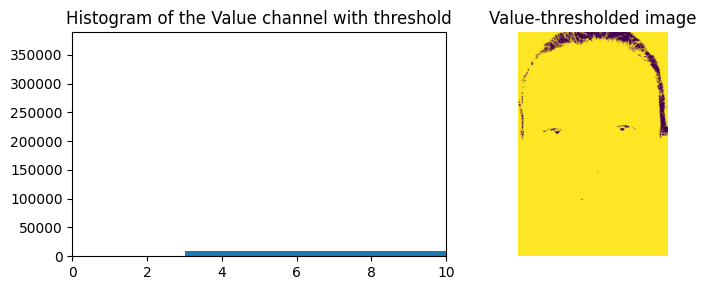

In [20]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
v = img_hsv[:,:,2]
hue_threshold = 50
binary_img = v > hue_threshold

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

ax0.hist(v.ravel(), 10)
ax0.set_title("Histogram of the Value channel with threshold")
ax0.axvline(x=hue_threshold, color='r', linestyle='dashed', linewidth=2)
ax0.set_xbound(0, 10)
ax1.imshow(binary_img)
ax1.set_title("Value-thresholded image")
ax1.axis('off')

fig.tight_layout()